# Methodology

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from joblib import dump, load
from surprise.dataset import Dataset
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise.reader import Reader

random_state = 14 # My wife's favorite number!

## Data preprocessing

### Cull first encounters
Let's begin by pulling in our first encounters data.

In [2]:
# Read in the first encounters data
df_fe = pd.read_csv('data/first_encounters.csv', encoding='utf-8', index_col='ordinal')

C:\Users\emq\anaconda3\envs\wie\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Our first step will be to cull the data, so that we're left only with users and items that have a significant amount of interactions.

In [4]:
# Get user encounter counts
user_encounter_counts = df_fe.groupby('user_id')['correct_response'].count()
user_encounter_counts.describe()

count    85802.000000
mean        97.347078
std        522.900077
min          1.000000
25%         14.000000
50%         24.000000
75%         54.000000
max      17944.000000
Name: correct_response, dtype: float64

The 25th percentile encountered 14 items or fewer; the 50th percentile encountered 24 items or fewer. A game of _Which Is English?_ is usually about 14 items, so those folks beneath the 25th percentile only played one game. Ideally, we want users who played more than that, and also, we'd like to limit our data to a manageable size. Let's put our threshold, then, at the 50th percentile.

In [17]:
# Cull significant users
user_sig = user_encounter_counts[user_encounter_counts > user_encounter_counts.quantile(0.5)]

Now let's select only items that have a history with our "significant" users.

In [18]:
# Cull items that interacted with significant users
item_encounter_counts = df_fe[df_fe['user_id'].isin(user_sig.index)].groupby('item_id')['correct_response'].count()
item_encounter_counts.describe()

count    18081.000000
mean       432.402854
std        250.696392
min          1.000000
25%        256.000000
50%        348.000000
75%        612.000000
max       1562.000000
Name: correct_response, dtype: float64

The 25th percentile has plenty of interactions, so we'll use that as our threshold.

In [19]:
# Cull significant items
item_sig = item_encounter_counts[item_encounter_counts > item_encounter_counts.quantile(0.25)]

# How many users and items are we left with?
print(f'users: {user_sig.shape[0]}', f'items: {item_sig.shape[0]}')

users: 42200 items: 13517


### Fill in sparse data
#### Perform SVD
We already know that our data is sparse; not every user has interacted with every item. If we're planning to use machine learning to make predictions, we're going to have to fill in our matrix. [Funk SVD](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD) has the amazing ability to fill sparse user-item interaction data like ours with predictions, so let's try it out!

**Although Funk SVD is normally used to predict user ratings on items, I'm choosing to view correct and incorrect answers as "ratings" of items. Theoretically, predictions should reflect a user's likelihood to get an item correct. This is the "big trick" I've come up with to avoid using more traditional [computerized adaptive testing](https://en.wikipedia.org/wiki/Computerized_adaptive_testing) techniques (which would be the fallback approach if this one doesn't work).**

We're using [Surprise](http://surpriselib.com/) for this, so first we need to create a trainset from our first encounters, fit the SVD algorithm with the trainset, then reconstruct the matrix from the resulting factorizations.

_NOTE: For operations that create large artifacts, I try to load cached versions before recreating them from scratch._

In [21]:
# Make trainset
cached_trainset_path = 'cached/trainset.joblib'
try:
    # Load trainset
    trainset = load(cached_trainset_path)
except:
    # Build data reader with binary "rating scale" representing wrong and right answers
    reader = Reader(rating_scale=(0, 1))
    
    # Build trainset
    trainset = Dataset.load_from_df(df_sig_encounters, reader).build_full_trainset()
    
    # Save trainset
    dump(trainset, cached_trainset_path)

In [25]:
# Perform SVD
cached_svd_path = 'cached/svd.joblib'
try:
    # Load trained SVD object
    svd = load(cached_svd_path)
except:
    # Train SVD algorithm with the default 100 factors and 20 epochs
    svd = SVD(random_state=random_state).fit(trainset)
    
    # Save trained SVD object
    dump(svd, cached_svd_path)

#### Normalize the item biases
In the [Exploration](Exploration.ipynb#testings_testitem) notebook, I noted that the `est_rating` field of the `testings_testitem` SQL table was populated with ratings that indicated relative (not absolute) item difficulty that could not always be trusted. An exciting byproduct of SVD is the bias it generates for every item (and user), effectively providing us with a mathematically justifiable, absolute alternative! **We can interpret an item's bias as the "easiness" of that item, as a higher bias means a given user is more likely to answer it correctly.**

So now it's time for another sanity check: the item biases should theoretically correlate with the estimated ratings.

correlation: 0.9681455049433862


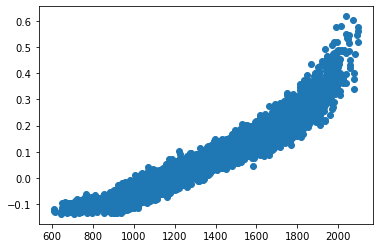

In [35]:
# Get axis labels for the trainset
user_ids = [trainset.to_raw_uid(user) for user in trainset.all_users()]
item_ids = [trainset.to_raw_iid(item) for item in trainset.all_items()]

# Associate item ids with item biases
item_biases = pd.Series(svd.bi, index=item_ids, name='item_bias')

# Get estimated ratings
df_est_ratings = pd.read_csv('data/testitem_active_est_rating.csv', encoding='utf-8', index_col='id')

# Do inverted item biases correlate positively with estimated ratings?
df_biases_ratings = df_est_ratings.merge(item_biases, left_index=True, right_index=True)
x_rating = df_biases_ratings['est_rating']
y_bias = -df_biases_ratings['item_bias']
print(f'correlation: {np.corrcoef(x_rating, y_bias)[0, 1]}')
plt.scatter(x_rating, y_bias)

Hey! Not bad! To me, this is strong evidence in favor of the conjecture that item biases generated from SVD can be used as a measure of item difficulty. With that shown, let's reconstruct the data and get our answer predictions!

#### Reconstruct the data
This was tricky for me! The formula for reconstructing a prediction is $\hat{r}_{ui} = \mu + b_u + b_i + q_i^Tp_u$, where:

- $\mu$ is the global mean
- $b_u$ is the user bias
- $b_i$ is the item bias
- $q_i^T$ is the factored item matrix, transposed
- $p_u$ is the factored user matrix

At first, I reconstructed the data without adding the global mean. That threw everything off, and I despaired until I realized my mistake!

Anyway, let's construct it the right way now.